1. check data 
2. check fiducial features

In [116]:
# wavelet

In [117]:
# segmentation 👌done
# ui tkinter test saved in a separated file ,not preprcessed before
# fiducial features 👌done 

In [118]:
# reveiw project and test again  👌done
# save some array in text files to read later for testing ok 👌done
# then tkinter

In [119]:
import os
import numpy as np
import pandas as pd
import scipy.io
import scipy
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from scipy.signal import butter,filtfilt,savgol_filter

import matplotlib.pyplot as plt
# from scipy import signal
from scipy.signal import butter,filtfilt
import warnings
warnings.filterwarnings('ignore')
import glob
import wfdb as wf
from fiducial_features_11_points  import get_fiducial_features

In [120]:
s2=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\chosen\p_156\s0299lre'
s3=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\chosen\p_165\s0322lre'
s5=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\p_174\s0300lre'
s7=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\p_184\s0363lre'
s8=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\p_185\s0336lre'
s9=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\p_198\s0402lre'
s10=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\sub_150\s0287lre'
s13=r'F:\mohamed\4th_year_new\Semester 2\HCI\Project\ptb diagnostic healthy subs\sub260\s0496_re'

In [121]:
def ecg_isoline_drift_correction(ecg_signal, sampling_rate):

    # Apply a high-pass filter to remove baseline wander and DC drift
    b, a = butter(2, 0.5 / (sampling_rate / 2), 'highpass')
    ecg_filtered = filtfilt(b, a, ecg_signal)

    # Estimate the isoelectric line (baseline) using a moving average filter
    window_size = int(sampling_rate * 0.2)  # 200 ms window size
    baseline = savgol_filter(ecg_filtered, window_size, 1)

    # Subtract the estimated baseline from the filtered ECG signal
    ecg_corrected = ecg_filtered - baseline

    return ecg_corrected

In [122]:
def butter_bandbass_filter(Input_signal,low_cutoff,high_cutoff,sampling_rate,order=4):
    nyq=0.5*sampling_rate #nyquist sampling
    low=low_cutoff/nyq
    high=high_cutoff/nyq
    
    numerator,denominator=butter(order,[low,high],btype='band',output='ba',analog=False,fs=None)
    filtered=filtfilt(numerator,denominator,Input_signal)
    
    return filtered

# primary for the whole signal 

# start project code

In [123]:
files=[s2,s5,s13,s9,]#s8
# [s2,s3,s5,s7,s9,s10,s8,s13]#are the best after long analysis
files

['F:\\mohamed\\4th_year_new\\Semester 2\\HCI\\Project\\ptb diagnostic healthy subs\\chosen\\p_156\\s0299lre',
 'F:\\mohamed\\4th_year_new\\Semester 2\\HCI\\Project\\ptb diagnostic healthy subs\\p_174\\s0300lre',
 'F:\\mohamed\\4th_year_new\\Semester 2\\HCI\\Project\\ptb diagnostic healthy subs\\sub260\\s0496_re',
 'F:\\mohamed\\4th_year_new\\Semester 2\\HCI\\Project\\ptb diagnostic healthy subs\\p_198\\s0402lre']

In [124]:
data={}
for idx,sub in enumerate(files):
    signal_array, fields=wf.rdsamp(sub)
    sig = signal_array[:,1]
    sname=f"sub_{idx+1}"
    data[sname]=sig

In [125]:
data

{'sub_1': array([ 0.2265,  0.218 ,  0.215 , ..., -0.4795, -0.4835, -0.485 ]),
 'sub_2': array([ 0.0235,  0.0245,  0.027 , ..., -0.2265, -0.228 , -0.233 ]),
 'sub_3': array([-0.3835, -0.386 , -0.3865, ...,  0.346 ,  0.3475,  0.343 ]),
 'sub_4': array([-2.408 , -2.408 , -2.4085, ...,  1.904 ,  1.9085,  1.9155])}

In [126]:
len(data['sub_1'])

115200

# split data to get newtest unseen data
train =[:80000]

test =[80000:85000]


In [127]:
# save testing
new_test={}
for key ,sig in data.items():
    new_test[key]=sig[80000:85000]
    np.savetxt(f'{key}_test_segment.txt',sig[80000:85000])

# Preprocessing
1. isoline_drift_correction
2. band pass filter 
3. Extract Fiducial features 11 points with segmentation

In [128]:
def preprocessing_11points(sig):
    
    ecg_corrected = ecg_isoline_drift_correction(sig, sampling_rate=1000)
    filtered_signal=butter_bandbass_filter(ecg_corrected,low_cutoff=2,high_cutoff=40,sampling_rate=1000,order=4)
    segments = get_fiducial_features(filtered_signal)
    return segments

sub_1 [ 0.2265  0.218   0.215  ... -0.4795 -0.4835 -0.485 ]
sub_2 [ 0.0235  0.0245  0.027  ... -0.2265 -0.228  -0.233 ]
sub_3 [-0.3835 -0.386  -0.3865 ...  0.346   0.3475  0.343 ]
sub_4 [-2.408  -2.408  -2.4085 ...  1.904   1.9085  1.9155]


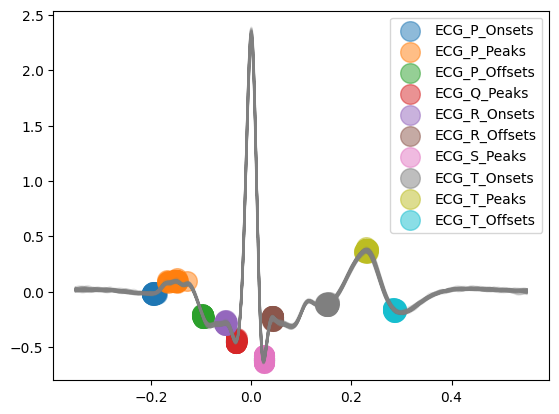

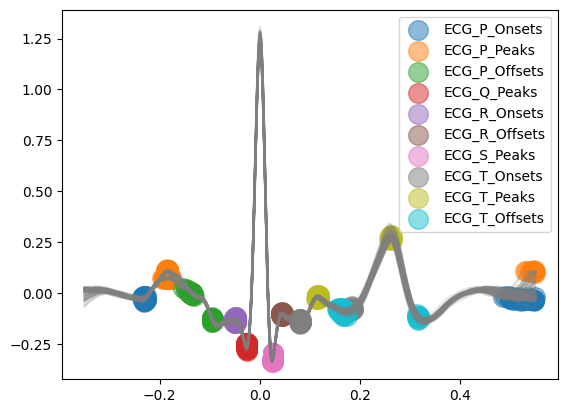

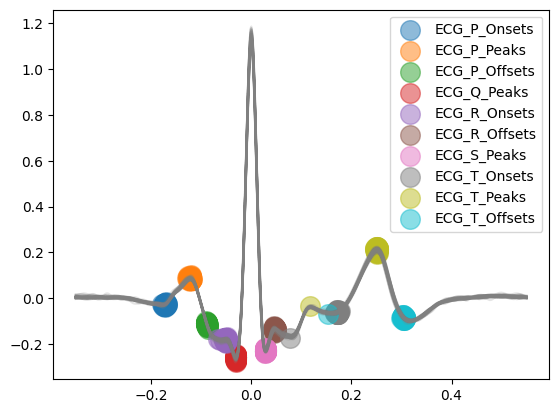

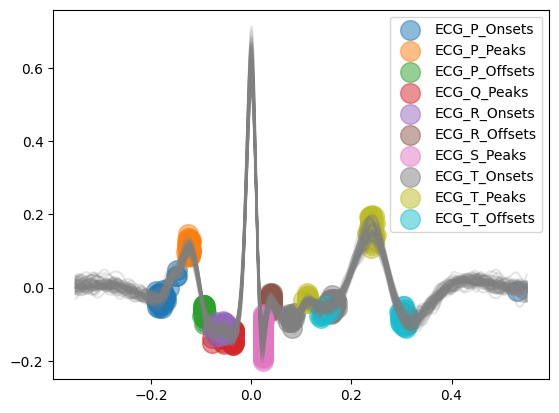

In [129]:
# training data
segments_dict={}
for key ,sig in data.items():
    print(key,sig)
    segments = preprocessing_11points(sig[:70000])
    
    segments_dict[key]=segments[2:52]

In [130]:
labels=[]
final_data=[]
for key ,signal in segments_dict.items():
    for s in signal:
        labels.append(key)
        final_data.append(s)

In [131]:
final_data=np.vstack(final_data)

labels=np.array(labels)

In [132]:
def get_sub(idx):
    return f'subject_{idx+1}'

# split data into train and test for our model 

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = train_test_split(final_data,labels, test_size=0.20,stratify=labels,shuffle=True,random_state=42)

lb=LabelEncoder()

y_train=lb.fit_transform(y_train)
y_test=lb.transform(y_test)

In [134]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

pickle.dump(sc,open('scalar.pkl','wb'))

In [135]:
y_train[:10]

array([1, 3, 3, 1, 3, 0, 2, 2, 2, 0], dtype=int64)

Text(0.5, 1.0, 'subject_2')

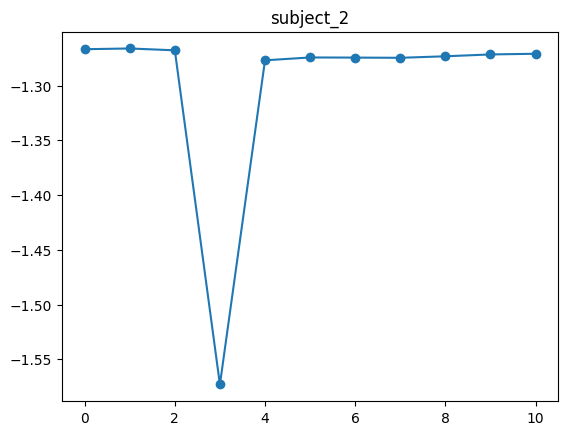

In [136]:
plt.plot(x[1],'-o')
plt.title(f'{get_sub(y_train[0])}')

# SVM

In [139]:
from sklearn import svm
from sklearn.metrics import accuracy_score ,classification_report,ConfusionMatrixDisplay,confusion_matrix

In [211]:
svm_classifier = svm.SVC(kernel='linear',C=100000) #error parameter
svm_classifier.fit(X=X_train,y=y_train)

pred=svm_classifier.predict(X_test)

print("Accuracy = {} % ".format(accuracy_score(y_test,pred)*100))

Accuracy = 95.0 % 


In [212]:
print(classification_report(y_test,pred,target_names=pd.unique(labels)))

              precision    recall  f1-score   support

       sub_1       1.00      0.90      0.95        10
       sub_2       0.91      1.00      0.95        10
       sub_3       1.00      1.00      1.00        10
       sub_4       0.90      0.90      0.90        10

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



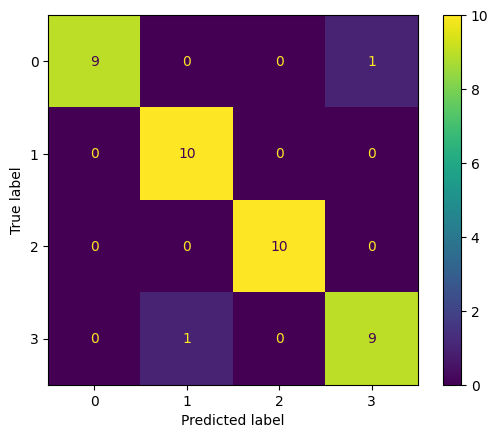

In [213]:
cm=confusion_matrix(y_test,pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

# LogisticRegression

In [225]:
from sklearn.linear_model import LogisticRegression

LR_classifier=LogisticRegression(C=100000,max_iter=10000)

LR_classifier.fit(X=X_train,y=y_train)

pred=LR_classifier.predict(X_test)

print("Accuracy = {} % ".format(accuracy_score(y_test,pred)*100))

Accuracy = 92.5 % 


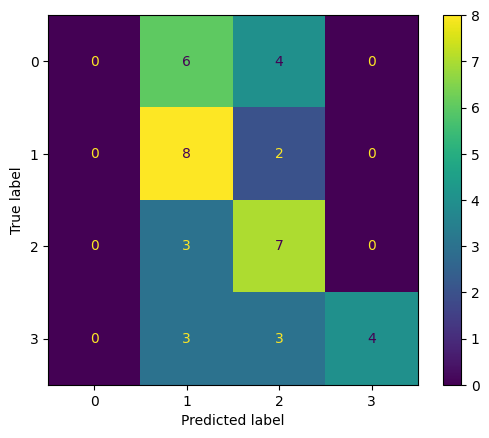

In [85]:
cm=confusion_matrix(y_test,pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

# LDA

In [226]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [227]:
LDA_classifier=LinearDiscriminantAnalysis(solver='eigen')

LDA_classifier.fit(X=X_train,y=y_train)

pred=LDA_classifier.predict(X_test)

print("Accuracy = {} % ".format(accuracy_score(y_test,pred)*100))

Accuracy = 97.5 % 


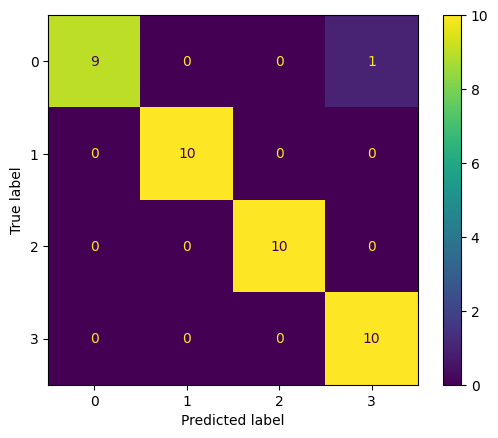

In [228]:
cm=confusion_matrix(y_test,pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

# saving models

In [66]:
import pickle

In [67]:
pickle.dump(LDA_classifier,open('LDA_classifier_11points.pkl','wb'))

# Loading and Testing

In [105]:
path='sub_2_test_segment.txt' 
to_test = np.loadtxt(path)

In [106]:
to_test.shape

(5000,)

In [107]:
def preprocessing_11points(sig):
    
    ecg_corrected = ecg_isoline_drift_correction(sig, sampling_rate=1000)
    filtered_signal=butter_bandbass_filter(ecg_corrected,low_cutoff=2,high_cutoff=40,sampling_rate=1000,order=4)
    segments = get_fiducial_features(filtered_signal)
    return segments

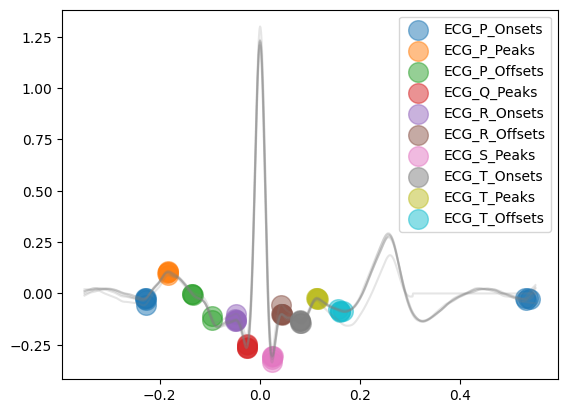

In [108]:
test=preprocessing_11points(to_test)

In [109]:
test

array([[1385, 1429, 1476,  808,  830,  857,  881,  900,  937,  970, 1016],
       [2151, 2196, 2245, 1564, 1585, 1612, 1636, 1656, 1692, 1726, 1777],
       [2911, 2956, 3006, 2333, 2354, 2381, 2405, 2425, 2460, 2493, 2537],
       [3673, 3718, 3806, 3092, 3112, 3139, 3164, 3182, 3221, 3254, 3299],
       [4467, 4512, 4599, 3852, 3875, 3902, 3926, 3944, 3982, 4016, 4062]],
      dtype=int64)

In [110]:
loaded_scalar=pickle.load(open('scalar.pkl','rb'))

test=loaded_scalar.transform(test)

In [111]:
test=np.expand_dims(test[2],axis=0)
test.shape

(1, 11)

In [112]:
loaded_model=pickle.load(open('LDA_classifier_11points.pkl','rb'))

In [113]:
loaded_model.n_features_in_

11

In [114]:
pred=loaded_model.predict(test)
pred

array([1], dtype=int64)

In [115]:
pred=pred[0]
get_sub(pred)

'subject_2'